# Easy21 - Prediction

EP-01 from IA Planning:MAC5788 - IME-USP

Github URL: https://github.com/vinicustod/easy21_pred

### Game Rules
- The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
- At the start of the game both the player and the dealer draw one black card (fully observed).
- Each turn the player may either stick or hit.
- If the player hits then she draws another card from the deck.
- If the player sticks she receives no further cards.
- The values of the player’s cards are added (black cards) or subtracted (red cards).
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1).
- If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

##### Implementation of Easy21 simulator
You should write an environment that implements the game Easy21. Specifically, write a function, named STEP, which takes as **input a state s** (dealer’s first card 1–10 and the player’s sum 1–21), **and an action a** (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for prediction and for control (in the next part of this EP) and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [1]:
import random
import numpy as np
import math
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

HIT = 0
STICK = 1
RED = 'red'
BLACK = 'black'
TERMINAL_STATE = "end"


class State:
    dealer = random.randint(1, 10)
    player = random.randint(1, 10)


class Policy:

    def get_action(self, state):
        pass


class RandomPolicy(Policy):

    def get_action(self, state):
        next_value = random.randint(0,1)
        return next_value

class PolicyHitUntil19(Policy):
    
    def get_action(self, state):
        return HIT if state <= 19 else STICK 

class Easy21Env:

    def __init__(self, seed=-1, policy=RandomPolicy()):
        if seed != -1:
            random.seed(seed)
        self.policy = policy

    @staticmethod
    def get_card():
        return random.randint(1, 10)

    @staticmethod
    def get_color():
        return RED if random.random() < 1 / 3 else BLACK

    def draw(self, state):
        card = self.get_card()
        if self.get_color() == BLACK:
            state += card
        else:
            state -= card

        return state

    def step(self, state, action):
        if action == HIT:
            state.player = self.draw(state.player)
            if state.player < 1 or state.player > 21:
                return TERMINAL_STATE, -1.0
            else:
                return state, 0.0
        else:
            while state.dealer < 17:
                state.dealer = self.draw(state.dealer)
                if state.dealer < 1 or state.dealer > 21:
                    return TERMINAL_STATE, 1.0

            if state.dealer > state.player:
                return TERMINAL_STATE, -1.0
            elif state.dealer == state.player:
                return TERMINAL_STATE, 0.0
            else:
                return TERMINAL_STATE, 1.0

    def create_episodes(self, number_of_episodes=1000):
        episodes = []

        for current_episode in range(number_of_episodes):
            state = State()
            state.player = random.randint(1, 10)
            state.dealer = random.randint(1, 10)
            episode = []

            while state != TERMINAL_STATE:
                action = self.policy.get_action(state.player)
                dealer = state.dealer
                player = state.player

                new_state, reward = self.step(state, action)
                episode.append((dealer, player, action, reward))
                
                state = new_state

            episodes.append(episode)


        return episodes

In [2]:
def sub_plot(values, name, names):
#     plt.clf()
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, to_plot in enumerate(values):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        x = range(10)
        y = range(21)
        X, Y = np.meshgrid(y, x)
        
        value, counter = to_plot
        ax.plot_wireframe(Y+1, X+1, value[1:, 1:])
        ax.set_xlabel('Dealer Cards')
        ax.set_ylabel('Player Card')
        ax.set_zlabel(r'$v_{\pi}$')
        ax.title.set_text(names[i])
    fig.suptitle(name)
    
    plt.show()


def plot_v_function(value, name):
#     plt.clf()
    fig = plt.figure()
    sliced_value = value[1:, 1:]
    plt.imshow(sliced_value, cmap='jet')
    plt.ylabel('Dealer card')
    plt.xlabel('Player card')
    plt.xticks(np.arange(21)+1)
    plt.yticks(np.arange(10)+1)
    plt.gca().invert_yaxis()
    fig.suptitle(name)
    plt.colorbar()
    
    plt.show()
    
def plot_wire(value, name):
#     plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = range(10)
    y = range(21)
    X, Y = np.meshgrid(y, x)
    ax.plot_wireframe(Y+1, X+1, value[1:, 1:])
    ax.set_xlabel('Dealer Cards')
    ax.set_ylabel('Player Card')
    ax.set_zlabel(r'$v_{\pi}$')
    fig.suptitle(name)
    
    plt.show()


First of all, we will generate the episodes that will be used thoughout the project.

In [3]:
easy21env = Easy21Env(seed=21, policy=PolicyHitUntil19())
episodes = easy21env.create_episodes(number_of_episodes=1000000)

easy21env2 = Easy21Env(seed=21)
episodes_random_policy = easy21env2.create_episodes(number_of_episodes=1000000)

The algorithms are not dependent only on this set of episodes, you're able to create new episodes and pass them as parameter, to do so in the end of the first set you have to store the value and the counter to start the second set from where the first have stopped. Then you can always create new episodes to improve your policy evaluation. 

#### Monte Carlo Prediction

In [4]:
def monte_carlo_prediction(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None):
    for episode in episodes:
        g = 0
        for dealer, player, action, reward in episode:
            g += reward

        for dealer, player, action, reward in episode:
            n[dealer, player] += 1
            a = 1 / n[dealer, player]
            v[dealer, player] = v[dealer, player] + a * (g - v[dealer, player])

    return v, n

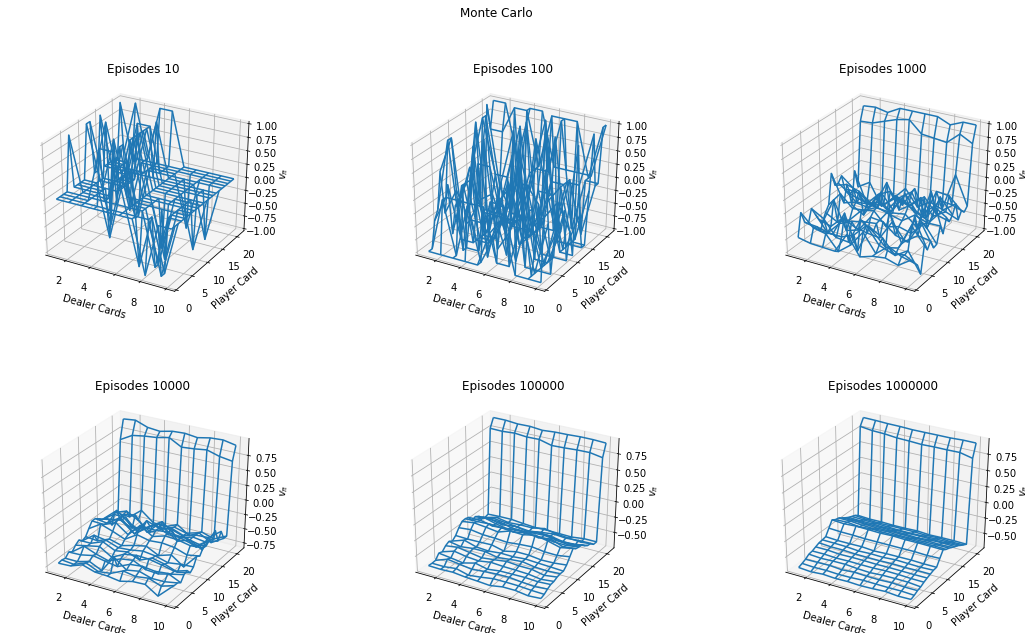

In [5]:
mc_value_vec = []
episodes_name = []
for i in range(6):
    episodes_num = 10**(i+1)
    episodes_name.append("Episodes " + str(episodes_num))
    mc_value_vec.append(monte_carlo_prediction(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes[:episodes_num]))

sub_plot(mc_value_vec, 'Monte Carlo', episodes_name)

In the graphs above we can we can see that after 10000 episodes $v_{\pi}$ already have a defined form, and last two grpahs with 100000 and 1 million episodes, we can see the form being adjusted. As will see, the following algorithms TD(0) and TD($\lambda$) will have the same behaviour.

#### TD(0) Prediction

In [6]:
def td0(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None):
    for episode in episodes:
        for current_index in range(len(episode)):            
            dealer, player, action, reward = episode[current_index]
            n[dealer, player] += 1

            a = 1 / n[dealer, player]

            if current_index+1 < len(episode):
                next_dealer, next_player, _, _ = episode[current_index+1]

                v[dealer, player] = v[dealer, player] + a * (
                            reward + v[next_dealer, next_player] - v[dealer, player])
            else:
                v[dealer, player] = v[dealer, player] + a * (
                        reward + 0 - v[dealer, player])
                
    return v, n

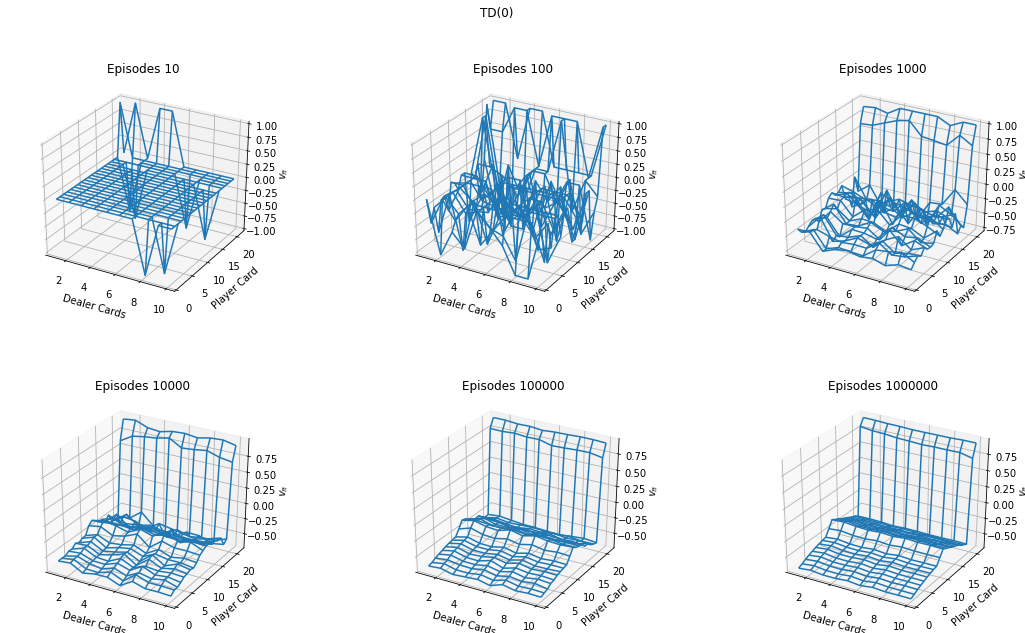

In [7]:
td0_value_vec = []
episodes_name = []
for i in range(6):
    episodes_num = 10**(i+1)
    episodes_name.append("Episodes " + str(episodes_num))
    td0_value_vec.append(td0(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes[:episodes_num]))

sub_plot(td0_value_vec, 'TD(0)', episodes_name)

In [8]:
def td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None, scaling=0):
    for episode in episodes:
        for j in range(len(episode)):
            dealer, player, action, reward = episode[j]
            reward_sum = 0
            g_total = 0
            maxstep = (len(episode) - j)
                        
            for next_index in range(maxstep):
                lookaheadstate = next_index + j
                dealer1, player1, _, reward1 = episode[lookaheadstate]
                
                if lookaheadstate < len(episode)-1: 
                    dealer2, player2, _, _ = episode[lookaheadstate+1]
                    nextstatevalue = v[dealer2, player2]
                
                    reward_sum = reward_sum + reward1
                    g = reward_sum + nextstatevalue

                    if (maxstep - 1) == next_index and scaling == 1.0:
                        g_total += math.pow(scaling, next_index) * g
                    else:
                        g_total += (1.0 - scaling) * math.pow(scaling, next_index) * g
                else:
                    nextstatevalue = 0
                
                    reward_sum = reward_sum + reward1
                    g = reward_sum + nextstatevalue

                    if (maxstep - 1) == next_index and scaling == 1.0:
                        g_total += math.pow(scaling, next_index) * g
                    else:
                        g_total += (1.0 - scaling) * math.pow(scaling, next_index) * g

            n[dealer, player] += 1
            a = 1.0 / n[dealer, player]
            v[dealer, player] = v[dealer, player] + a * (g_total - v[dealer, player])

    return v, n

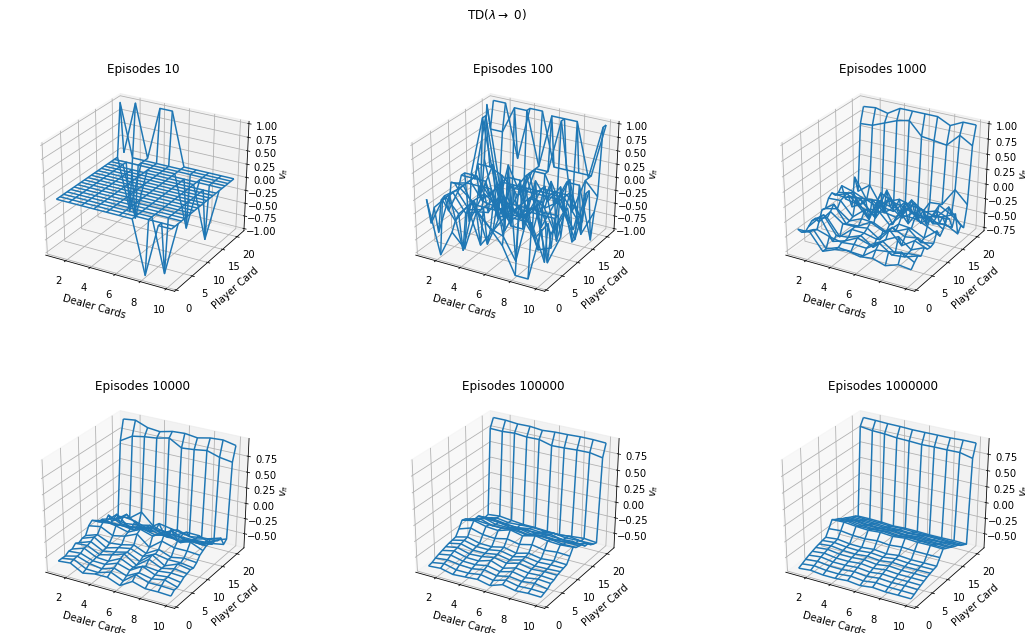

In [9]:
lam = 0
td_lam_value_vec = []
episodes_name = []
for i in range(6):
    episodes_num = 10**(i+1)
    episodes_name.append("Episodes " + str(episodes_num))
    td_lam_value_vec.append(td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes[:episodes_num], scaling=lam))

sub_plot(td_lam_value_vec, r'TD($\lambda \rightarrow$ {value_l})'.format(value_l=lam), episodes_name)


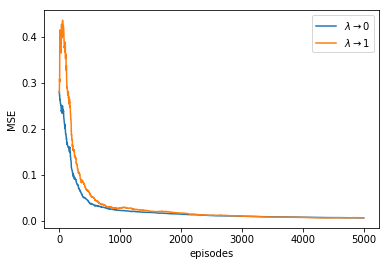

In [10]:
mc_value, counter = monte_carlo_prediction(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes)
msq = np.zeros((2,len(episodes[:5000])))
for k in range(2):
    td_value = np.zeros((11,22))
    td_counter = np.zeros((11,22))
    for i, episode in enumerate(episodes[:5000]):
        td_value, td_counter = td(td_value, td_counter, [episode], scaling=k*1)
        msq[k, i] = np.sum(np.square(mc_value - td_value)) / (11*22)

plt.clf()        
plt.plot(np.arange(len(episodes[:5000])), msq[0],label=r'$\lambda \rightarrow 0$')
plt.plot(np.arange(len(episodes[:5000])), msq[1],label=r'$\lambda \rightarrow 1$')
plt.ylabel("MSE")
plt.xlabel("episodes")
plt.legend()

plt.show()

Above we have the Mean Square Error for the TD($\lambda$) with lambda equal 0 and 1 against the $v_{\pi}$ of **MC** with 1 million episodes. As its shown in the graph after 5000 episodes the Mean Square error is already stabilizing.

**- What are the pros and cons of bootstrapping in Easy21:prediction?**

The cons of using bootstrapping is the bias introduce by the initial values, since you're using the values availables. The pro is that you don't have to wait until the end of the episode to have a value.

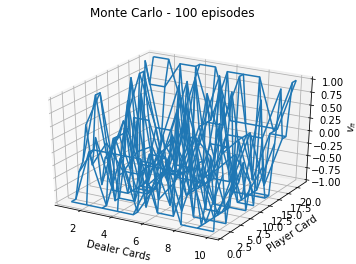

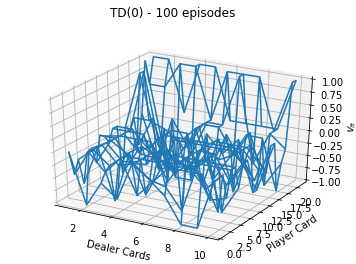

In [11]:
plot_wire(mc_value_vec[1][0], "Monte Carlo - 100 episodes")
plot_wire(td0_value_vec[1][0], "TD(0) - 100 episodes")

As we can see in the graphs above with $v_{\pi}$ after 100 episodes, **MC** have bigger variance and the **TD(0)** have the bias introduce by initial value (in this case being initialized with 0).

- **Would you expect bootstrapping to help more in blackjack or Easy21:prediction? Why?**

Bootstrapping is more likely to help more on the Easy21, since the episodes can be longer due to the RED cards, but it will also depend on the policy being used, if the policy is likely to select **STICK** then the episodes will be shorther and bootstraping will not being as useful as if the policy is more likely of select **HIT**.

- Verify that TD($\lambda \rightarrow 0$) equivalent to TD(0)


As we can see below, the Mean Square Error of TD($\lambda \rightarrow 0$) against the TD0 is zero.

In [12]:
v_td0, counter = td0(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes)
v_td_lam_0, counter = td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes, scaling=0)

mse_td0 = np.sum(np.square(v_td0 - v_td_lam_0)) / (11*22)
print(mse_td0)

0.0


- Verify that TD($\lambda \rightarrow 1$) equivalent to MC

As it follow the Mean square error from the TD($\lambda \rightarrow 1$) is equal zero, when compared against Monte Carlo

In [13]:
v_td_lam_1, counter = td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes, scaling=1)

print(np.sum(np.square(mc_value - v_td_lam_1)) / (11*22))

0.0


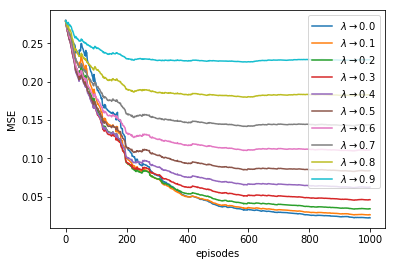

In [14]:
msq = np.zeros((10,len(episodes[:1000])))

for k in range(10):
    td_value = np.zeros((11,22))
    td_counter = np.zeros((11,22))
    for i in range(len(episodes[:1000])):
        td_value, td_counter = td(td_value, td_counter, [episodes[i]], k*0.1)
        msq[k, i] = np.sum(np.square(mc_value - td_value)) / (11*22)
    
    plt.plot(np.arange(len(episodes[:1000])), msq[k],label=r'$\lambda \rightarrow {lam:.1f}$'.format(lam=k*0.1))

plt.ylabel("MSE")
plt.xlabel("episodes")
plt.legend()

plt.show()

In this graph above we have all the Mean square errors for $\lambda$ varying from 0 to 0.9, increasing 0.1

### Policy 50/50

The following graphs show $v_{\pi}$ for the second policy after 100000 episodes, this policy is defined as 50% **STICK** and 50% of **HIT**.

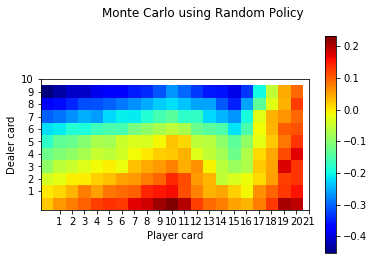

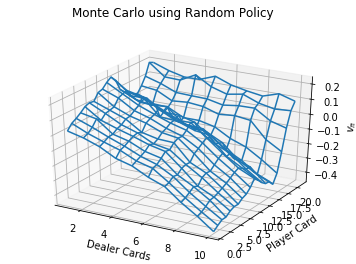

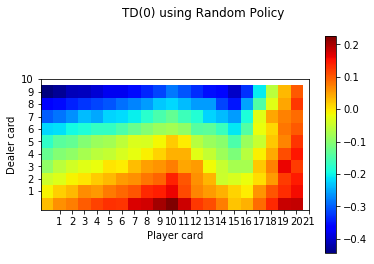

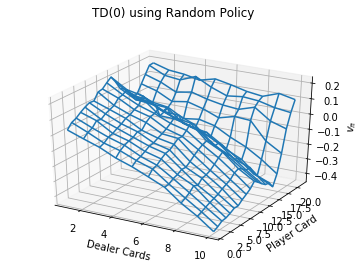

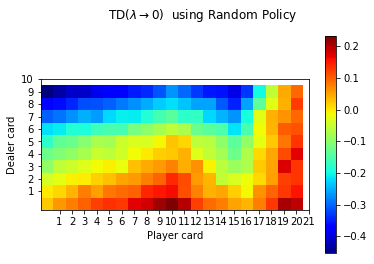

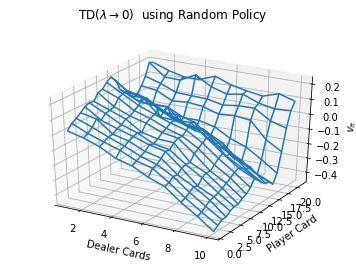

In [15]:
v_mc_random, _ = monte_carlo_prediction(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes_random_policy)
plot_v_function(v_mc_random, "Monte Carlo using Random Policy")
plot_wire(v_mc_random, "Monte Carlo using Random Policy")


v_td0_random, _ = td0(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes_random_policy)
plot_v_function(v_td0_random, "TD(0) using Random Policy")
plot_wire(v_td0_random, "TD(0) using Random Policy")


v_tdl_random, _ = td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=episodes_random_policy, scaling=1)
plot_v_function(v_tdl_random, r'TD($\lambda \rightarrow 0$)  using Random Policy')
plot_wire(v_tdl_random, r'TD($\lambda \rightarrow 0$)  using Random Policy')



Color meaning: 
- Warmer: odds are in favor of the player
- Cold: odds are in favor of the dealer 

As we can see, in this policy the player have better chances of winning when having a value closer to 10 and the dealer have a low card value or when the player have 18 or more.